In [ ]:
import numpy as np
import plotly.graph_objects as go

# --- CUBE GEOMETRY DEFINITION ---
# A cube has 8 vertices. We define their (x, y, z) coordinates.
vertices = np.array(
    [
        [0, 0, 1],
        [0, 1, 1],
        [1, 1, 1],
        [1, 0, 1],
        [0, 0, 0],
        [0, 1, 0],
        [1, 1, 0],
        [1, 0, 0],
    ]
)
# A cube has 12 edges, indexed 0-11. Each edge connects two vertices.
edges = np.array(
    [
        [0, 1],
        [1, 2],
        [2, 3],
        [3, 0],
        [4, 0],
        [5, 1],
        [6, 2],
        [7, 3],
        [4, 5],
        [5, 6],
        [6, 7],
        [7, 4],
    ]
)

In [ ]:
# --- FUNCTION TO FILTER FOR CONNECTED EDGES ---
def is_connected(visibility_vector, edges_array):
    """
    Checks if the graph formed by active edges is a single connected component.
    
    Args:
        visibility_vector (np.array): A 12-element binary vector.
        edges_array (np.array): The global (12, 2) array defining cube edges.

    Returns:
        bool: True if the shape is connected, False otherwise.
    """
    active_edge_indices = np.where(visibility_vector == 1)[0]
    
    # An empty shape (no edges) is not considered connected for this purpose.
    if len(active_edge_indices) == 0:
        return False

    # 1. Build an adjacency list for the graph and find all active vertices
    adj_list = {i: [] for i in range(8)} # 8 vertices in a cube
    active_vertices = set()

    for edge_idx in active_edge_indices:
        u, v = edges_array[edge_idx]
        adj_list[u].append(v)
        adj_list[v].append(u)
        active_vertices.add(u)
        active_vertices.add(v)
        
    # 2. Perform a Depth-First Search (DFS) traversal
    start_node = next(iter(active_vertices)) # Get an arbitrary start node
    stack = [start_node]
    visited = set()
    
    while stack:
        node = stack.pop()
        if node not in visited:
            visited.add(node)
            for neighbor in adj_list[node]:
                stack.append(neighbor)
    
    # 3. If the traversal visited all active vertices, the graph is connected
    return len(visited) == len(active_vertices)

In [ ]:
# --- FUNCTION TO PLOT A CUBE ---
def plot_incomplete_cube(visibility_vector):
    """
    Takes a binary vector and draws the corresponding cube edges in an interactive 3D plot.

    Args:
        visibility_vector (list or np.array): An array of 12 numbers (0s or 1s).
    """
    if len(visibility_vector) != 12:
        raise ValueError("visibility_vector must have a length of 12.")

    # These lists will hold the coordinates for the lines to be drawn.
    # We use 'None' to create breaks in the line, so each edge is separate.
    x_coords = []
    y_coords = []
    z_coords = []

    # Iterate through each of the 12 edges
    for i, is_visible in enumerate(visibility_vector):
        # If the vector at this index is 1, we draw the edge
        if is_visible == 1:
            # Get the indices of the start and end vertices for the current edge
            vertex_indices = edges[i]
            start_vertex = vertices[vertex_indices[0]]
            end_vertex = vertices[vertex_indices[1]]

            # Add start vertex coordinates
            x_coords.append(start_vertex[0])
            y_coords.append(start_vertex[1])
            z_coords.append(start_vertex[2])

            # Add end vertex coordinates
            x_coords.append(end_vertex[0])
            y_coords.append(end_vertex[1])
            z_coords.append(end_vertex[2])

            # Add None to break the line before the next edge
            x_coords.append(None)
            y_coords.append(None)
            z_coords.append(None)

    # Create the figure
    fig = go.Figure()

    # Add the 3D line trace for the cube edges
    fig.add_trace(
        go.Scatter3d(
            x=x_coords,
            y=y_coords,
            z=z_coords,
            mode="lines",
            line=dict(color="#22d3ee", width=8),
            hoverinfo="none",
        )
    )

    # Update the layout for a clean, cube-like appearance
    fig.update_layout(
        title="Interactive 3D Cube",
        paper_bgcolor="#111827",  # Dark background
        plot_bgcolor="#111827",
        scene=dict(
            xaxis=dict(visible=False, range=[-0.2, 1.2]),
            yaxis=dict(visible=False, range=[-0.2, 1.2]),
            zaxis=dict(visible=False, range=[-0.2, 1.2]),
            # This ensures the cube looks like a cube and not a stretched box
            aspectmode='cube',
        ),
        margin=dict(l=0, r=0, b=0, t=40),
    )

    # Show the interactive plot
    fig.show()


# --- FUNCTION TO PLOT MANY CUBES IN A LINE ---
def plot_all_incomplete_cubes(cubes_to_plot, active_sides=None):
    """
    Takes a list of binary vectors and draws the corresponding cubes in a line.
    If active_sides is specified, it filters the list first.
    
    Args:
        cubes_to_plot (list or np.array): A list/array of 12-element binary vectors.
        active_sides (int, optional): If provided, only cubes with this many
                                     visible sides will be plotted. Defaults to None.
    """
    # 1. Filter the cubes if a specific number of sides is requested
    if active_sides is not None:
        title = f"Rotationally Unique Cubes with {active_sides} Edges"
        # The list comprehension efficiently filters the array
        filtered_cubes = [
            cube for cube in cubes_to_plot if np.sum(cube) == active_sides
        ]
    else:
        title = "Rotationally Unique Cubes"
        filtered_cubes = cubes_to_plot

    if not filtered_cubes:
        print(f"No cubes found with {active_sides} active sides.")
        return

    # These lists will hold the coordinates for ALL lines to be drawn.
    x_coords, y_coords, z_coords = [], [], []
    
    # 2. Generate coordinates for each cube with an offset
    x_offset = 0
    spacing = 2.0 # The distance between the centers of the cubes

    for visibility_vector in filtered_cubes:
        for i, is_visible in enumerate(visibility_vector):
            if is_visible == 1:
                vertex_indices = edges[i]
                start_vertex = vertices[vertex_indices[0]]
                end_vertex = vertices[vertex_indices[1]]
                
                # Apply the horizontal offset to the X coordinates
                x_coords.extend([start_vertex[0] + x_offset, end_vertex[0] + x_offset, None])
                y_coords.extend([start_vertex[1], end_vertex[1], None])
                z_coords.extend([start_vertex[2], end_vertex[2], None])
        
        # Increment the offset for the next cube
        x_offset += spacing

    # 3. Create and configure the plot
    fig = go.Figure()
    fig.add_trace(go.Scatter3d(
        x=x_coords, y=y_coords, z=z_coords,
        mode='lines',
        line=dict(color='#22d3ee', width=5),
        hoverinfo='none'
    ))

    # Adjust the scene to fit all the cubes
    x_range = x_offset - spacing + 2.0
    y_range = 2.0
    z_range = 2.0

    fig.update_layout(
        title=title,
        paper_bgcolor="#111827",
        plot_bgcolor="#111827",
        scene=dict(
            xaxis=dict(visible=False, range=[-0.5, x_offset - spacing + 1.5]),
            yaxis=dict(visible=False, range=[-0.5, 1.5]),
            zaxis=dict(visible=False, range=[-0.5, 1.5]),
            # Set aspectmode to 'manual' and provide the ratio of the data ranges.
            # This ensures that a unit of length is the same in all directions.
            aspectmode='manual',
            aspectratio=dict(x=x_range, y=y_range, z=z_range)
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )
    fig.show()

In [ ]:
all_cubes = np.load("new_cubes.npy")
print(f"{all_cubes.shape=}")

all_cubes.shape=(218, 12)


In [ ]:
tridimensional_cubes = []
for cube in all_cubes:
    x_dir = np.r_[1,3,9,11]
    y_dir = np.r_[0,2,8,10]
    z_dir = np.r_[4,5,6,7]
    if any(cube[x_dir]) and any(cube[y_dir]) and any(cube[z_dir]):
        tridimensional_cubes.append(cube)
tridimensional_cubes = np.stack(tridimensional_cubes)
print(f"{tridimensional_cubes.shape=}")

tridimensional_cubes.shape=(176, 12)


In [ ]:
filtered_cubes = np.stack([c for c in tridimensional_cubes if is_connected(c, edges)])
print(f"{filtered_cubes.shape=}")

filtered_cubes.shape=(123, 12)


[0 0 0 0 0 1 1 1 1 1 1 1]
[0 0 0 0 1 1 1 1 0 1 1 1]
[0 0 0 1 0 0 1 1 1 1 1 1]
[0 0 0 1 0 1 0 1 1 1 1 1]
[0 0 0 1 0 1 1 1 0 1 1 1]
[0 0 0 1 0 1 1 1 1 0 1 1]
[0 0 0 1 0 1 1 1 1 1 0 1]
[0 0 0 1 0 1 1 1 1 1 1 0]
[0 0 0 1 1 0 0 1 1 1 1 1]
[0 0 0 1 1 0 1 0 1 1 1 1]
[0 0 0 1 1 0 1 1 0 1 1 1]
[0 0 0 1 1 0 1 1 1 1 0 1]
[0 0 0 1 1 0 1 1 1 1 1 0]
[0 0 0 1 1 1 0 0 1 1 1 1]
[0 0 0 1 1 1 0 1 0 1 1 1]
[0 0 0 1 1 1 0 1 1 1 1 0]
[0 0 0 1 1 1 1 0 0 1 1 1]
[0 0 0 1 1 1 1 0 1 0 1 1]
[0 0 0 1 1 1 1 0 1 1 0 1]
[0 0 0 1 1 1 1 0 1 1 1 0]
[0 0 0 1 1 1 1 1 0 1 1 0]
[0 0 0 1 1 1 1 1 1 0 1 0]
[0 0 0 1 1 1 1 1 1 1 0 0]
[0 0 1 1 0 1 0 1 1 1 0 1]
[0 0 1 1 0 1 0 1 1 1 1 0]
[0 0 1 1 0 1 1 0 1 0 1 1]
[0 0 1 1 0 1 1 0 1 1 0 1]
[0 0 1 1 1 0 1 0 1 1 0 1]
[0 0 1 1 1 1 0 0 0 1 1 1]
[0 0 1 1 1 1 0 0 1 1 1 0]
[0 0 1 1 1 1 1 0 0 1 0 1]
[0 0 1 1 1 1 1 0 1 0 1 0]
n=32


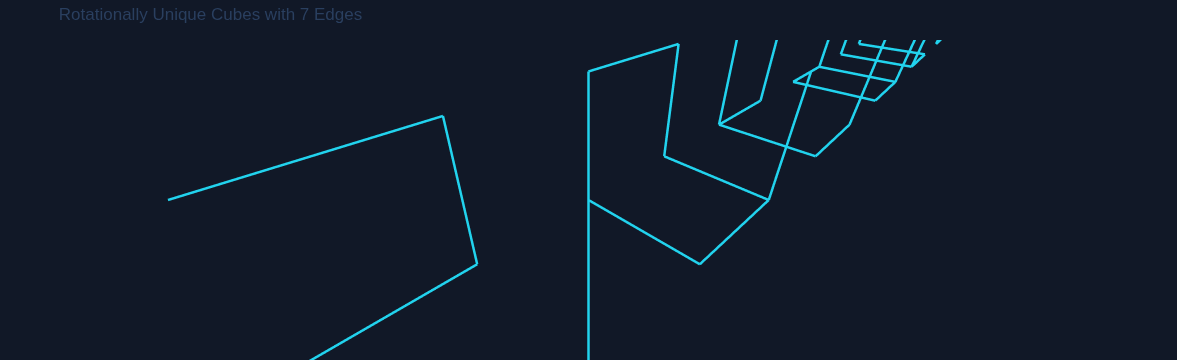

In [ ]:
selected_cubes = filtered_cubes

active_sides_to_plot = 7
n = 0
for idx, cube in enumerate(selected_cubes):
    if np.sum(cube) - active_sides_to_plot == 0:
        print(cube)
        # plot_incomplete_cube(filtered_cubes[idx])
        n += 1
print(f"{n=}")

plot_all_incomplete_cubes(selected_cubes, active_sides=active_sides_to_plot)